### Descriptions:

Inputs:

- `1_4_cohort_test_results.csv`: original prediction at time 0 & 24, old data
- `6_7_cohort4_test.csv`: prediction at time 0 & 24, new validation data
- `14_cohort_final_test2.csv`: prediction at time 0 - 24, new data, new cohort, with old split
- `14_cohort_final_test.csv`: prediction at time 0 - 24, new data, new cohort, with new split

In [5]:
library(ggplot2)
library(ggExtra)
library(tidyverse)
library(lubridate)
library(gridExtra)
library(pROC)
library(ROCR)
library(ROCit)
library(caret)
library(boot)
library(gbm)

library(cvAUC)
library(MLmetrics)
library(cowplot)

In [6]:
# directories
datadir0 = "../../DataTD/"
cohortdir = "../../OutputTD/1_cohort"
# featuredir = "../../OutputTD/2_features"
modeldir0 = "../../OutputTD/3_models/1_4_cohort"

datadir6 = "../../DataTD/validation"
valdir = "../../OutputTD/6_validation"
modeldir6 = "../../OutputTD/6_validation/models"
datadir = "../../DataTD/shc2021"
outdir = "../../OutputTD/shc2021"
modeldir = "../../OutputTD/shc2021/models" # new split new data
modeldir2 = "../../OutputTD/shc2021/models2" # old split new data

figuredir0 = "../../OutputTD/Figures"
figuredir = "../../OutputTD/shc2021/figures"

# display rows and cols
options(repr.matrix.max.rows=250, repr.matrix.max.cols=30)

In [25]:
results0 <- read.csv(file.path(modeldir0, '1_4_cohort_test_results.csv'))
nrow(results0)
results6 <- read.csv(file.path(valdir, '6_7_cohort4_test.csv'))
nrow(results6)

results2 <- read.csv(file.path(outdir, '14_cohort_final_test2.csv'))
nrow(results2)
results <- read.csv(file.path(outdir, '14_cohort_final_test.csv'))
nrow(results)

[1] 12418

[1] 16484

[1] 14113

[1] 7664

In [26]:
head(results0, 1)
head(results6, 1)
head(results2, 1)
head(results, 1)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,adm_year,transfer,pred_death_24hr_max,pred_death_24hr_recent,pred_first,diff0_24,abs_diff0_24,diff0_True,diff24_True
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,JCe8840f,131264906504,34995073,2019-02-14 22:22:00,0,0,0,1,0,0,0,0,0,0,0,0,0,2019,0,0.2811781,0.2091965,0.2356759,0.03,0,0.24,0.21


,anon_id,pat_enc_csn_id_coded,admit_time,first_label,death_24hr_recent_label,adm_year,adm_month,p1,p24
,<chr>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,JC1000116,131295313275,2020-09-29 22:45:00,0,0,2020,9,0.02273415,0.01132414


,anon_id,pat_enc_csn_id_coded,admit_time,first_label,death_3hr_recent_label,death_6hr_recent_label,death_9hr_recent_label,death_12hr_recent_label,death_24hr_recent_label,adm_year,adm_month,p1,p12,p24,p3,p6,p9
,<chr>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,JC1000116,131295313275,2020-09-29 22:45:00,0,0,0,0,0,0,2020,9,0.0105307,0.01123712,0.01291768,0.01066307,0.01426807,0.01092208


,anon_id,pat_enc_csn_id_coded,admit_time,first_label,death_3hr_recent_label,death_6hr_recent_label,death_9hr_recent_label,death_12hr_recent_label,death_24hr_recent_label,adm_year,adm_month,p1,p12,p24,p3,p6,p9
,<chr>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,JC1001688,131302440087,2021-02-26 11:46:00,0,0,0,0,0,0,2021,2,0.1875911,0.1500773,0.1666534,0.2861808,0.194771,0.1378668


In [27]:
results0 <- results0 %>% select(anon_id, pat_enc_csn_id_coded, admit_time, 
                               first_label, death_24hr_recent_label, 
                               pred_first, pred_death_24hr_recent)

### Original

[1] 0.9072535

[1] 0.6422387

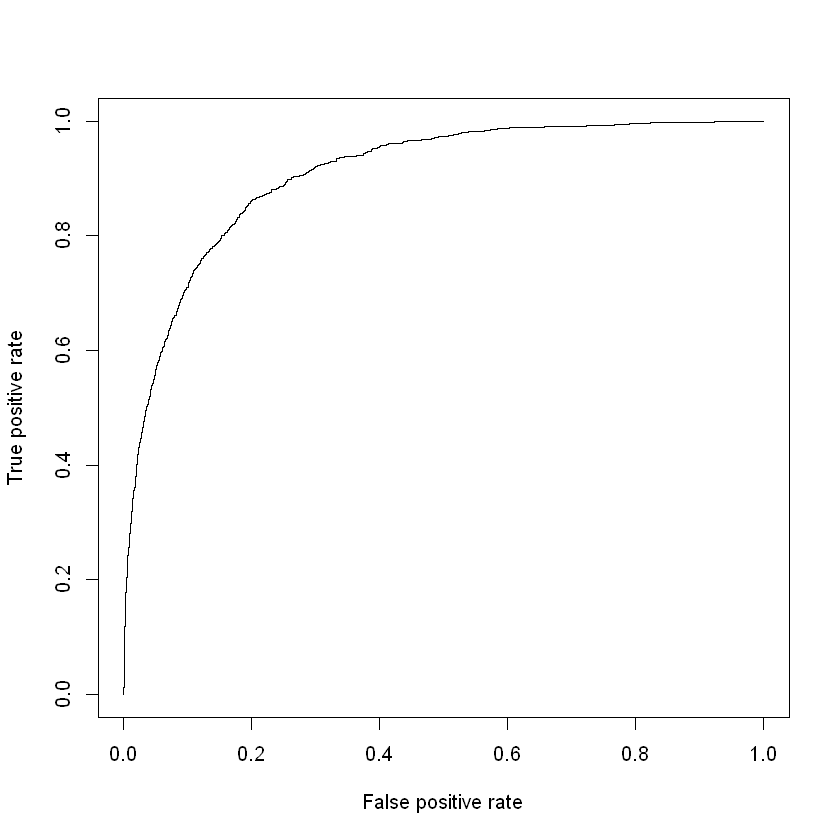

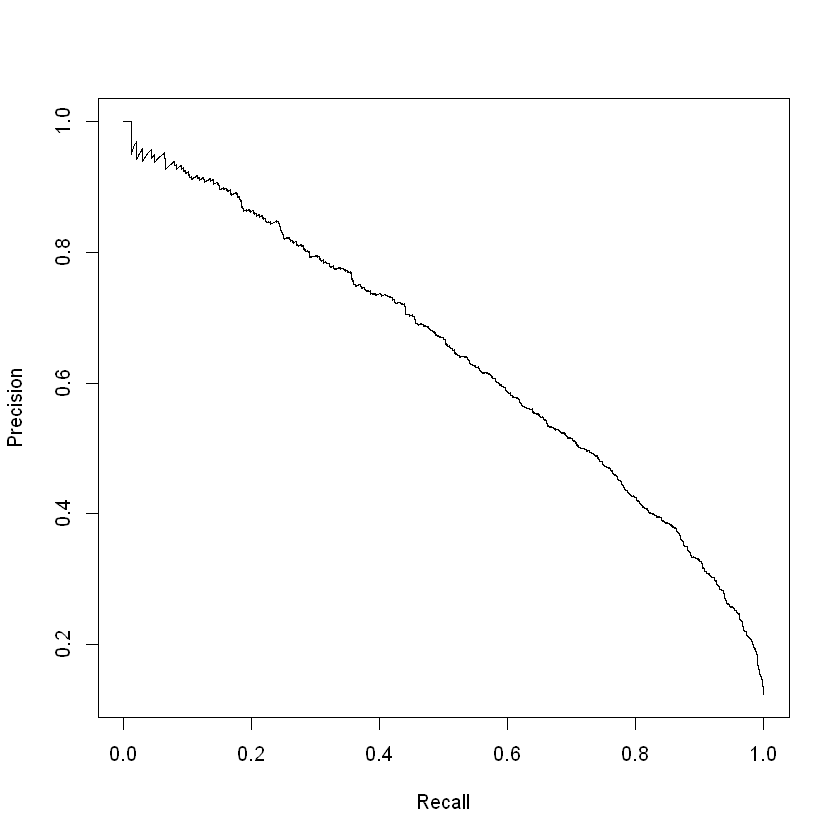

In [35]:
# original, time0
pred01_rocr = ROCR::prediction(results0$pred_first, results0$first_label)

# same here
pred_rocr = pred01_rocr

# AUROC
ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
roc_perf <- ROCR::performance(pred_rocr,"tpr","fpr")
plot(roc_perf)

# AUPRC
ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]
prc_perf <- ROCR::performance(pred_rocr, "prec", "rec")
plot(prc_perf)

# acc = ROCR::performance(pred_rocr, measure = "acc", x.measure = "cutoff")@y.values[[1]]
# mean(acc)

[1] 0.8527461

[1] 0.4911128

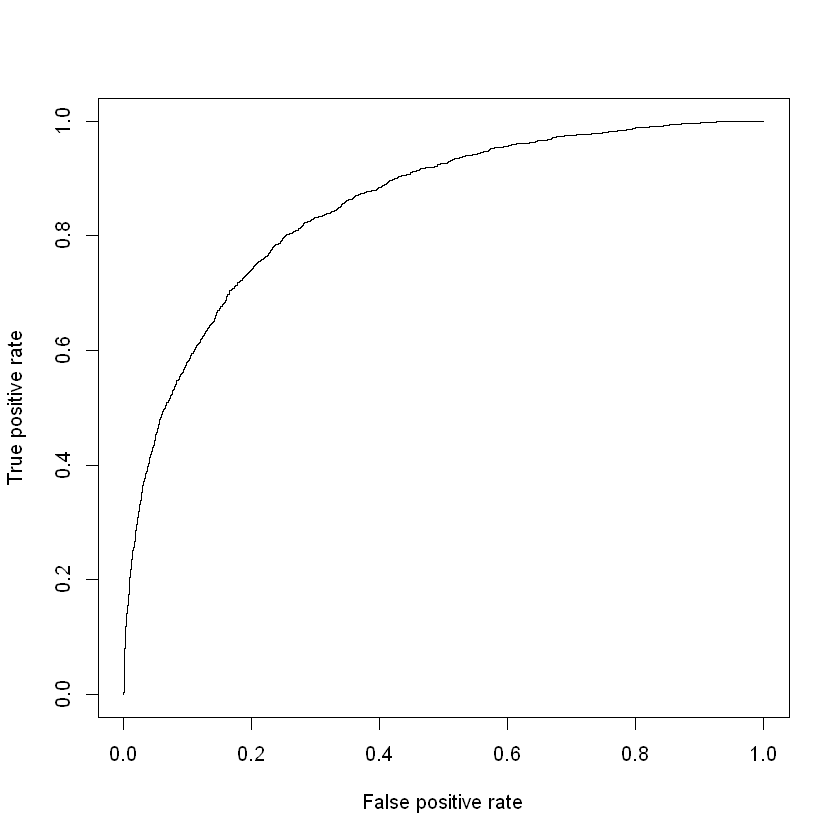

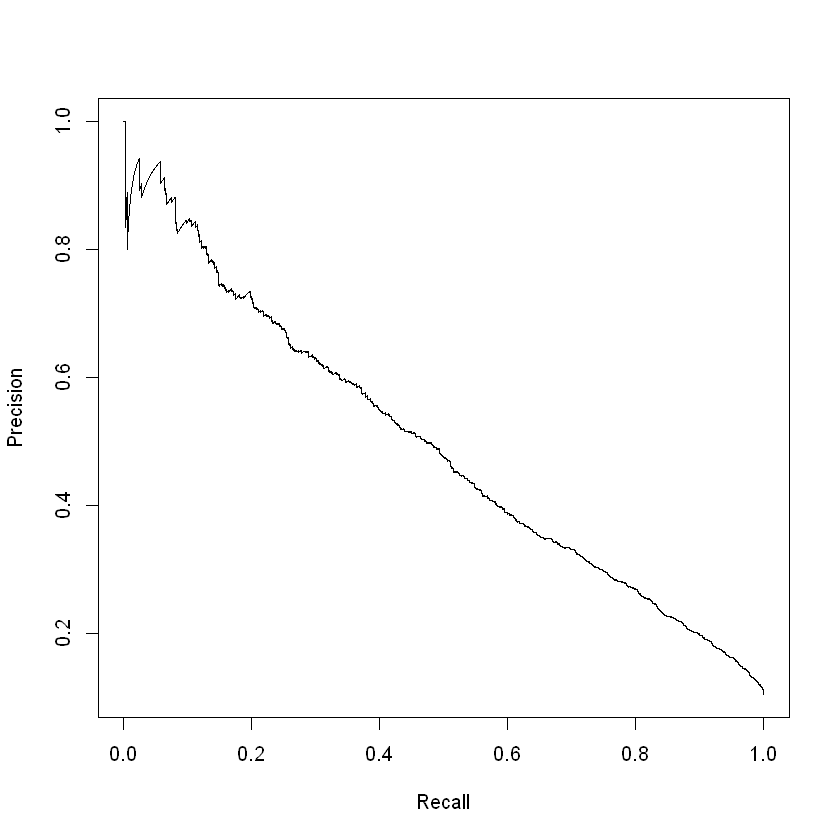

In [37]:
# original, time24
pred024_rocr = ROCR::prediction(results0$pred_death_24hr_recent,results0$death_24hr_recent_label)
# auc24 <- performance(pred24_rocr, measure = "auc")
# auc24 <- auc24@y.values[[1]]

pred_rocr = pred024_rocr

# AUROC
ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
roc_perf <- ROCR::performance(pred_rocr,"tpr","fpr")
plot(roc_perf)

# AUPRC
ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]
prc_perf <- ROCR::performance(pred_rocr, "prec", "rec")
plot(prc_perf)

In [49]:
# validation
pred60_rocr = ROCR::prediction(results6$p1, results6$first_label)
pred624_rocr = ROCR::prediction(results6$p24, results6$death_24hr_recent_label)

# AUROC
# ROCR::performance(pred60_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred624_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]

# AUPRC
# ROCR::performance(pred60_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred624_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

[1] 0.8744855

[1] 0.5410468

In [51]:
# new model old split, time0
pred21_rocr = ROCR::prediction(results2$p1, results2$first_label)
pred23_rocr = ROCR::prediction(results2$p3, results2$death_3hr_recent_label)
pred26_rocr = ROCR::prediction(results2$p6, results2$death_6hr_recent_label)
pred29_rocr = ROCR::prediction(results2$p9, results2$death_9hr_recent_label)
pred212_rocr = ROCR::prediction(results2$p12, results2$death_12hr_recent_label)
pred224_rocr = ROCR::prediction(results2$p24, results2$death_24hr_recent_label)

# AUROC
ROCR::performance(pred21_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred23_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred26_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred29_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred212_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred224_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]


# AUPRC
ROCR::performance(pred21_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred23_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred26_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred29_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred212_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred224_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

[1] 0.9204782

[1] 0.9125124

[1] 0.9092476

[1] 0.9036284

[1] 0.8999038

[1] 0.8834644

[1] 0.640243

[1] 0.6346987

[1] 0.6240912

[1] 0.6208858

[1] 0.6061731

[1] 0.5185265

In [52]:
# new model new split
pred1_rocr = ROCR::prediction(results$p1, results$first_label)
pred3_rocr = ROCR::prediction(results$p3, results$death_3hr_recent_label)
pred6_rocr = ROCR::prediction(results$p6, results$death_6hr_recent_label)
pred9_rocr = ROCR::prediction(results$p9, results$death_9hr_recent_label)
pred12_rocr = ROCR::prediction(results$p12, results$death_12hr_recent_label)
pred24_rocr = ROCR::prediction(results$p24, results$death_24hr_recent_label)

# AUROC
ROCR::performance(pred1_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred3_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred6_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred9_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred12_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred24_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]

# AUPRC
ROCR::performance(pred1_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred3_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred6_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred9_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred12_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]
ROCR::performance(pred24_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

[1] 0.9298159

[1] 0.9230154

[1] 0.916082

[1] 0.9117683

[1] 0.9043769

[1] 0.8944502

[1] 0.6500709

[1] 0.6443659

[1] 0.6320842

[1] 0.6360584

[1] 0.6187301

[1] 0.5311787

In [6]:
# confidence interval for AUROC, using cross validation
ci.cvAUC(results$pred_first, results$first_label)
ci.cvAUC(results$pred_death_24hr_recent, results$death_24hr_recent_label)

$cvAUC
[1] 0.9072535

$se
[1] 0.00379624

$ci
[1] 0.899813 0.914694

$confidence
[1] 0.95

$cvAUC
[1] 0.8527461

$se
[1] 0.005550637

$ci
[1] 0.8418670 0.8636251

$confidence
[1] 0.95

In [7]:
# confidence intervals for AUROC using delong and bootstrap methods
proc1 <- pROC::roc(results$first_label, results$pred_first)
# print(proc1)
print(ci.auc(proc1))
print(ci.auc(proc1, method = "bootstrap"))

proc24 <- pROC::roc(results$death_24hr_recent_label, results$pred_death_24hr_recent)
print(ci.auc(proc24))
print(ci.auc(proc24, method = "bootstrap"))

Setting levels: control = 0, case = 1

Setting direction: controls < cases



95% CI: 0.8998-0.9147 (DeLong)
95% CI: 0.8999-0.9145 (2000 stratified bootstrap replicates)


Setting levels: control = 0, case = 1

Setting direction: controls < cases



95% CI: 0.8419-0.8636 (DeLong)
95% CI: 0.8422-0.8645 (2000 stratified bootstrap replicates)


In [8]:
# bootstrapping for AUPRC, first labels
prcboot1 <- function(data, indices) {
    d <- data[indices, ] # allows boot to select sample
    pred_rocr <- ROCR::prediction(d$pred_first, d$first_label)
    pr <- ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]
    return(pr)
}
# bootstrapping with 2000 replications
results1 <- boot(results, prcboot1, R=2000)
# boot.ci(results1, type="norm")

In [9]:
# bootstrapping for AUPRC, 24hr labels
prcboot24 <- function(data, indices) {
    d <- data[indices, ] # allows boot to select sample
    pred_rocr <- ROCR::prediction(d$pred_death_24hr_recent, d$death_24hr_recent_label)
    pr <- ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]
    return(pr)
}
# bootstrapping with 2000 replications
results24 <- boot(data=results, statistic=prcboot24, R=2000)
# boot.ci(results24, type="norm")

In [10]:
# confidence intervals for AUPRC bootstrapping with different types, "bca" didn't work
boot.ci(boot.out = results1, type = c("norm", "basic", "perc"))
boot.ci(boot.out = results24, type = c("norm", "basic", "perc"))

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results1, type = c("norm", "basic", "perc"))

Intervals : 
Level      Normal              Basic              Percentile     
95%   ( 0.6224,  0.6726 )   ( 0.6211,  0.6725 )   ( 0.6120,  0.6634 )  
Calculations and Intervals on Original Scale

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results24, type = c("norm", "basic", "perc"))

Intervals : 
Level      Normal              Basic              Percentile     
95%   ( 0.4702,  0.5277 )   ( 0.4707,  0.5285 )   ( 0.4537,  0.5115 )  
Calculations and Intervals on Original Scale

### Calibration plots

In [8]:
colnames(results)

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "adm_year"                       
[19] "transfer"                        "pred_death_24hr_max"            
[21] "pred_death_24hr_recent"          "pred_first"                     
[23] "diff0_24"                        "abs_diff0_24"                   
[25] "diff0_True"                      "diff24_True"

,death_24hr_recent_label,pred_death_24hr_recent
,<int>,<dbl>
1,0,0.2091965
2,1,0.8461691
3,1,0.7147856
4,1,0.4850516
5,0,0.3480069
6,1,0.7169072



Call:
calibration.formula(x = as.factor(death_24hr_recent_label)
 ~ pred_death_24hr_recent, data = results, class = "1")

Models: pred_death_24hr_recent 
Event:  1 
Cuts: 11 

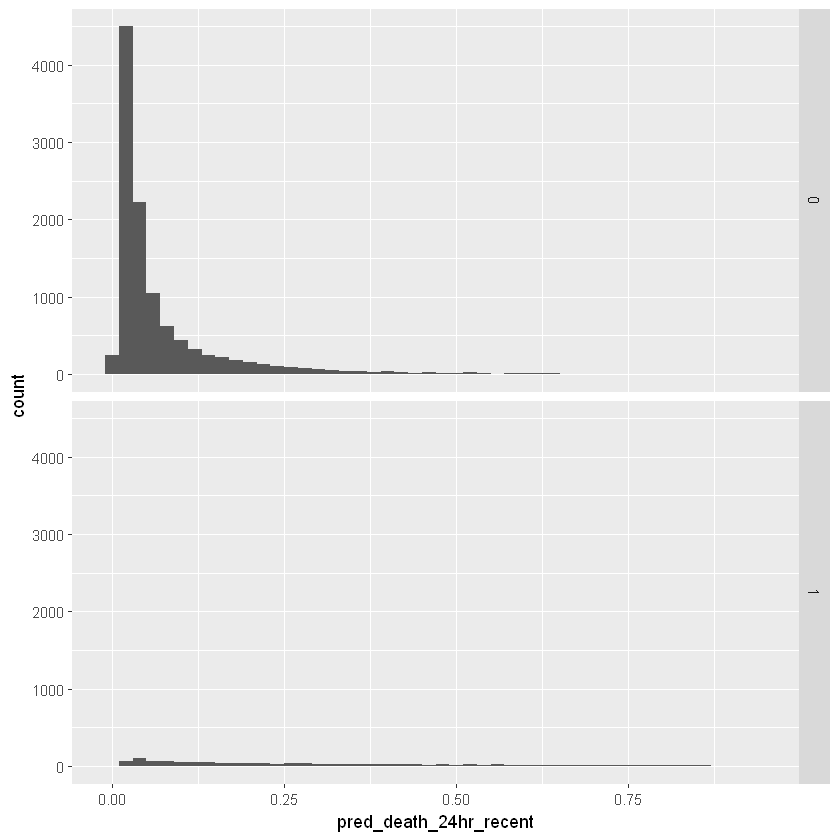

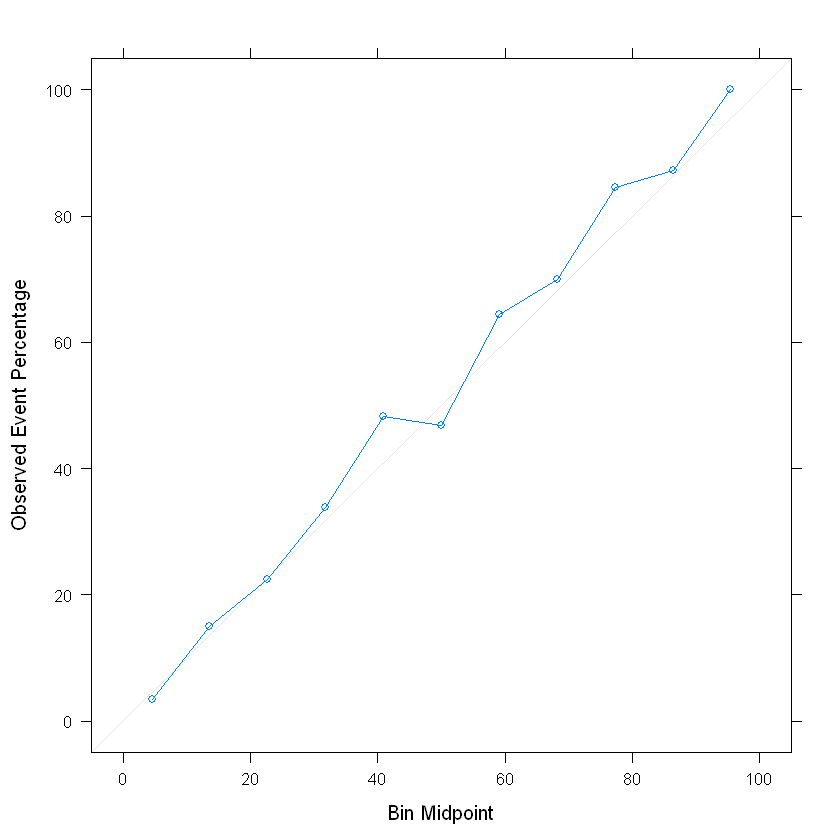

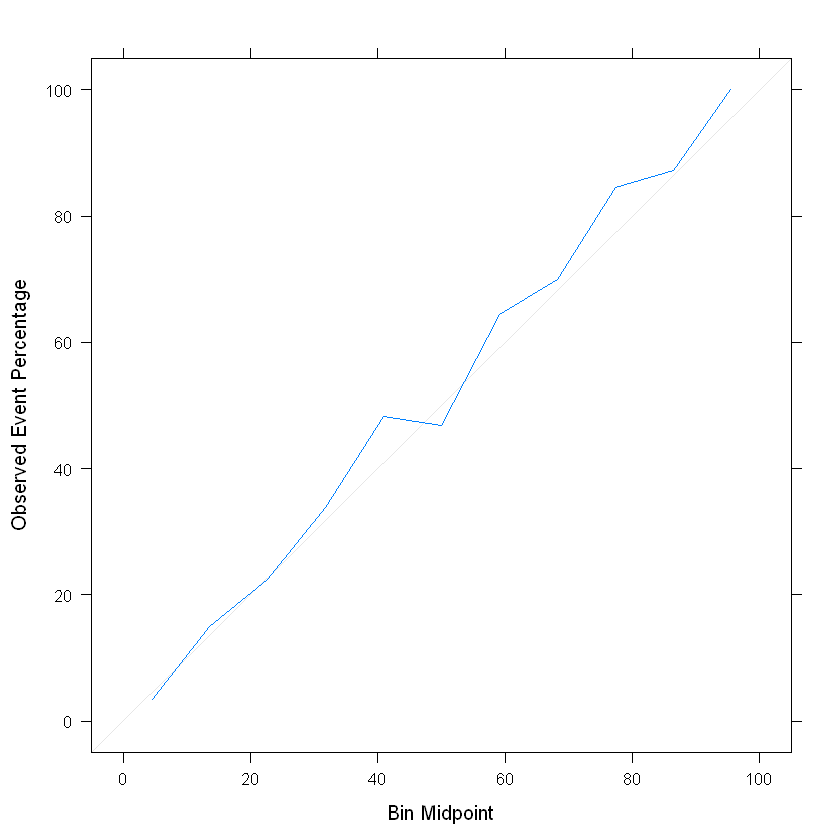

In [9]:
head(results[, c("death_24hr_recent_label", "pred_death_24hr_recent")])

softmaxHist <- ggplot(results, aes(x = pred_death_24hr_recent))
softmaxHist <- softmaxHist + geom_histogram(binwidth = 0.02)
softmaxHist + facet_grid(death_24hr_recent_label ~ .) + xlab("pred_death_24hr_recent")

calPlotData <- calibration(as.factor(death_24hr_recent_label) ~ pred_death_24hr_recent, class = '1', data = results)
calPlotData

xyplot(calPlotData)
plot(calPlotData, type = "l")

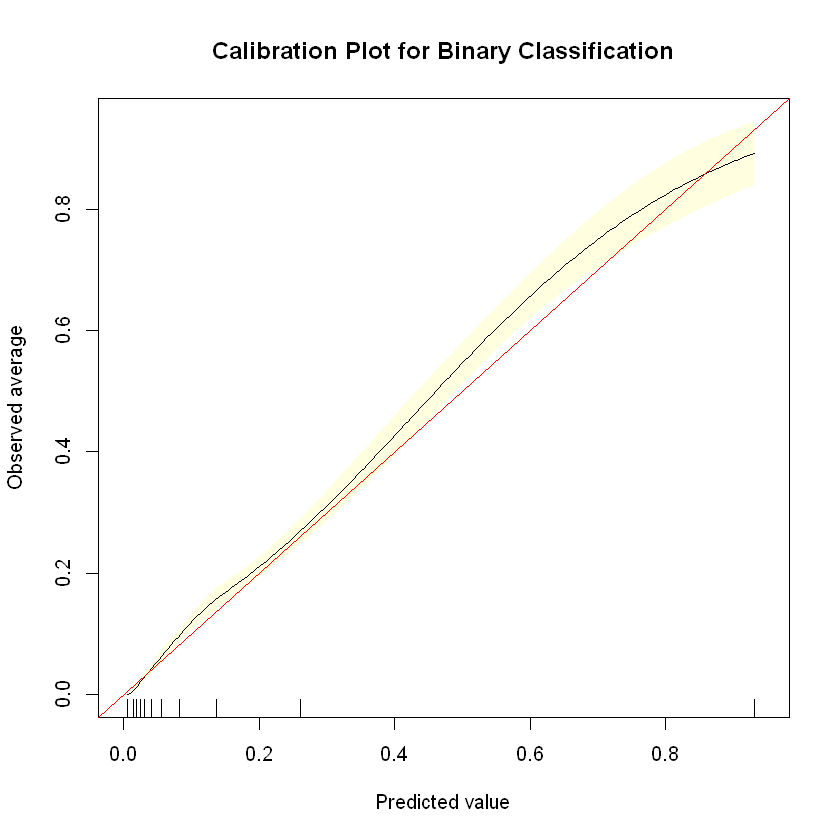

In [10]:
calibrate.plot(results$death_24hr_recent_label, results$pred_death_24hr_recent, 
               main="Calibration Plot for Binary Classification")

In [11]:
cal_plot_data24 = calibration(factor(death_24hr_recent_label) ~ pred_death_24hr_recent, 
  data = results, class = 1)$data
cal_plot_data24 <- cal_plot_data24 %>% mutate("Observed Average" = Percent/100, "Predicted Value" = midpoint/100)
cal_plot_data24

calibModelVar,bin,Percent,Lower,Upper,Count,midpoint,Observed Average,Predicted Value
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pred_death_24hr_recent,"[0,0.0909]",3.398707,3.033441,3.794617,305,4.545455,0.03398707,0.04545455
pred_death_24hr_recent,"(0.0909,0.182]",14.974293,13.236596,16.845270,233,13.636364,0.14974293,0.13636364
pred_death_24hr_recent,"(0.182,0.273]",22.482759,19.492044,25.699258,163,22.727273,0.22482759,0.22727273
pred_death_24hr_recent,"(0.273,0.364]",33.846154,29.160017,38.779681,132,31.818182,0.33846154,0.31818182
pred_death_24hr_recent,"(0.364,0.455]",48.221344,41.919190,54.565651,122,40.909091,0.48221344,0.40909091
pred_death_24hr_recent,"(0.455,0.545]",46.783626,39.126832,54.553843,80,50.000000,0.46783626,0.50000000
pred_death_24hr_recent,"(0.545,0.636]",64.444444,55.751245,72.488728,87,59.090909,0.64444444,0.59090909
pred_death_24hr_recent,"(0.636,0.727]",69.892473,59.502334,78.974065,65,68.181818,0.69892473,0.68181818
pred_death_24hr_recent,"(0.727,0.818]",84.615385,74.667867,91.789816,66,77.272727,0.84615385,0.77272727


In [12]:
cal_plot_data1 = calibration(factor(first_label) ~ pred_first, 
                             data = results, class = 1)$data
cal_plot_data1 <- cal_plot_data1 %>% mutate("Observed Average" = Percent/100, "Predicted Value" = midpoint/100)
cal_plot_data1

calibModelVar,bin,Percent,Lower,Upper,Count,midpoint,Observed Average,Predicted Value
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pred_first,"[0,0.0909]",2.260669,1.958136,2.595842,196,4.545455,0.02260669,0.04545455
pred_first,"(0.0909,0.182]",14.956405,13.182987,16.869050,223,13.636364,0.14956405,0.13636364
pred_first,"(0.182,0.273]",28.378378,24.981587,31.968076,189,22.727273,0.28378378,0.22727273
pred_first,"(0.273,0.364]",37.468983,32.726367,42.397098,151,31.818182,0.37468983,0.31818182
pred_first,"(0.364,0.455]",44.295302,38.569287,50.135869,132,40.909091,0.44295302,0.40909091
pred_first,"(0.455,0.545]",58.108108,51.320645,64.676063,129,50.000000,0.58108108,0.50000000
pred_first,"(0.545,0.636]",66.834171,59.826990,73.331045,133,59.090909,0.66834171,0.59090909
pred_first,"(0.636,0.727]",69.325153,61.632814,76.299261,113,68.181818,0.69325153,0.68181818
pred_first,"(0.727,0.818]",85.106383,78.138886,90.537982,120,77.272727,0.85106383,0.77272727


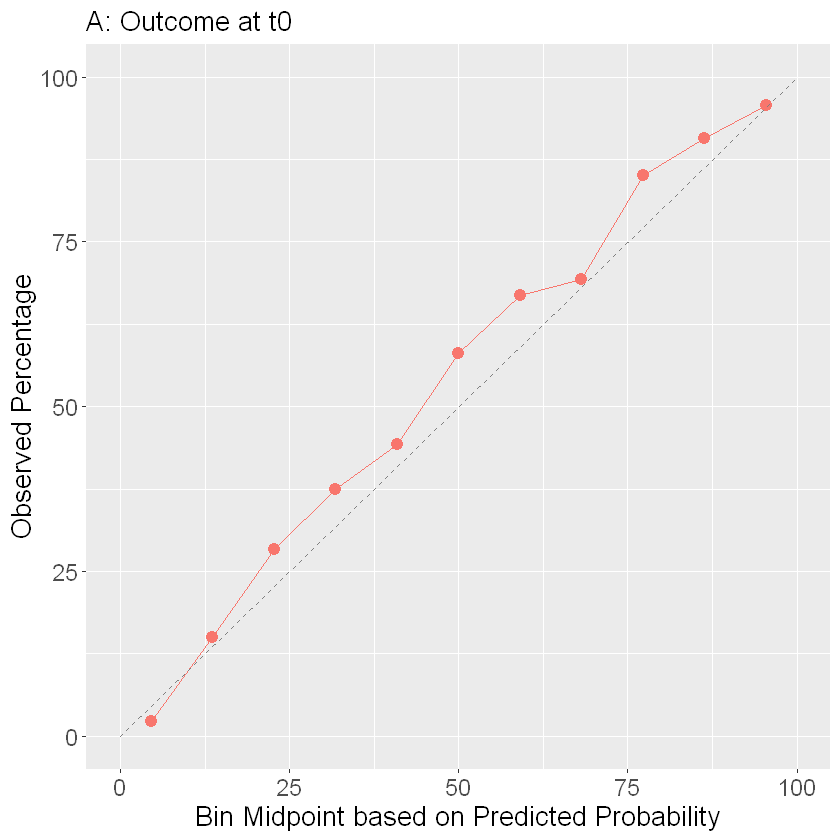

In [20]:
# plot
options(repr.plot.width=7, repr.plot.height=7)

c1 <- ggplot() + xlab("Bin Midpoint") +
          geom_line(data = cal_plot_data1, aes(midpoint, Percent),
                    color = "#F8766D") +
          geom_point(data = cal_plot_data1, aes(midpoint, Percent),
                    color = "#F8766D", size = 3) +
          geom_line(aes(c(0, 100), c(0, 100)), linetype = 2, 
                    color = 'grey50') +
          labs(x="Bin Midpoint based on Predicted Probability", y="Observed Percentage", 
              title = "A: Outcome at t0")

p1 <- c1 + theme(axis.text=element_text(size=14),
                 plot.title = element_text(size=16),
                 axis.title=element_text(size=16), legend.key.size = unit(1, "cm"))#, face="bold"

# ggsave("../Figures/calibration1.pdf", width = 12, height = 7, dpi = 1200)
p1

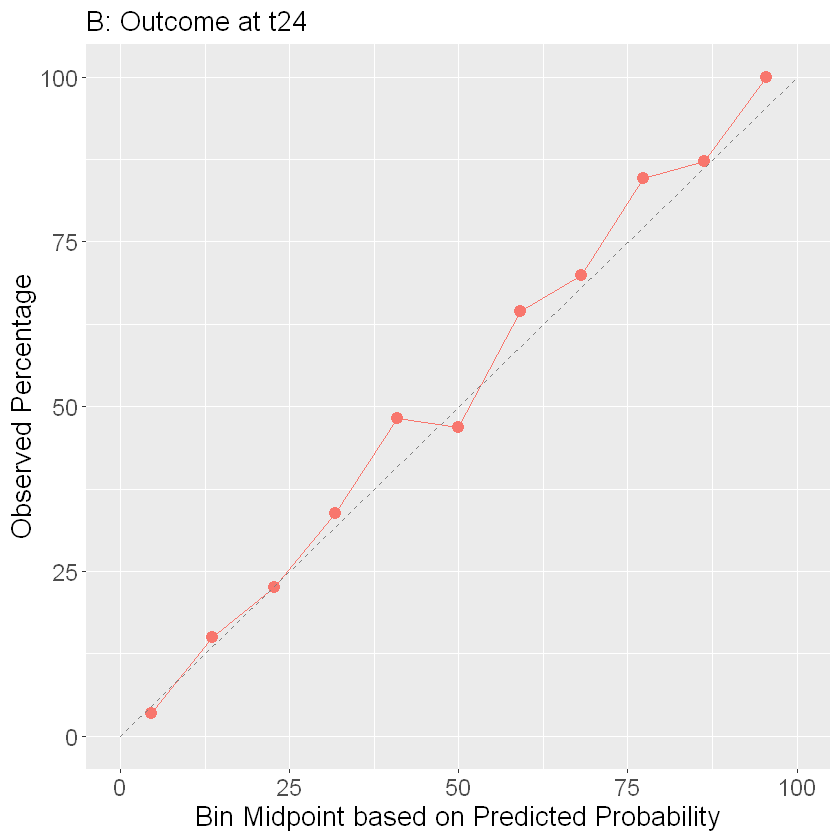

In [23]:
# plot
options(repr.plot.width=7, repr.plot.height=7)

c2 <- ggplot() + xlab("Bin Midpoint") +
          geom_line(data = cal_plot_data24, aes(midpoint, Percent),
                    color = "#F8766D") +
          geom_point(data = cal_plot_data24, aes(midpoint, Percent),
                    color = "#F8766D", size = 3) +
          geom_line(aes(c(0, 100), c(0, 100)), linetype = 2, 
                    color = 'grey50') +
          labs(x="Bin Midpoint based on Predicted Probability", y="Observed Percentage", 
               title = "B: Outcome at t24")

p2 <- c2 + theme(axis.text=element_text(size=14),
                 plot.title = element_text(size=16),
                 axis.title=element_text(size=16), legend.key.size = unit(1, "cm"))#, face="bold"

p2
# calibrate.plot(results$label_24hr_recent, results$lgbm24, main="Calibration Plot for Binary Classification")

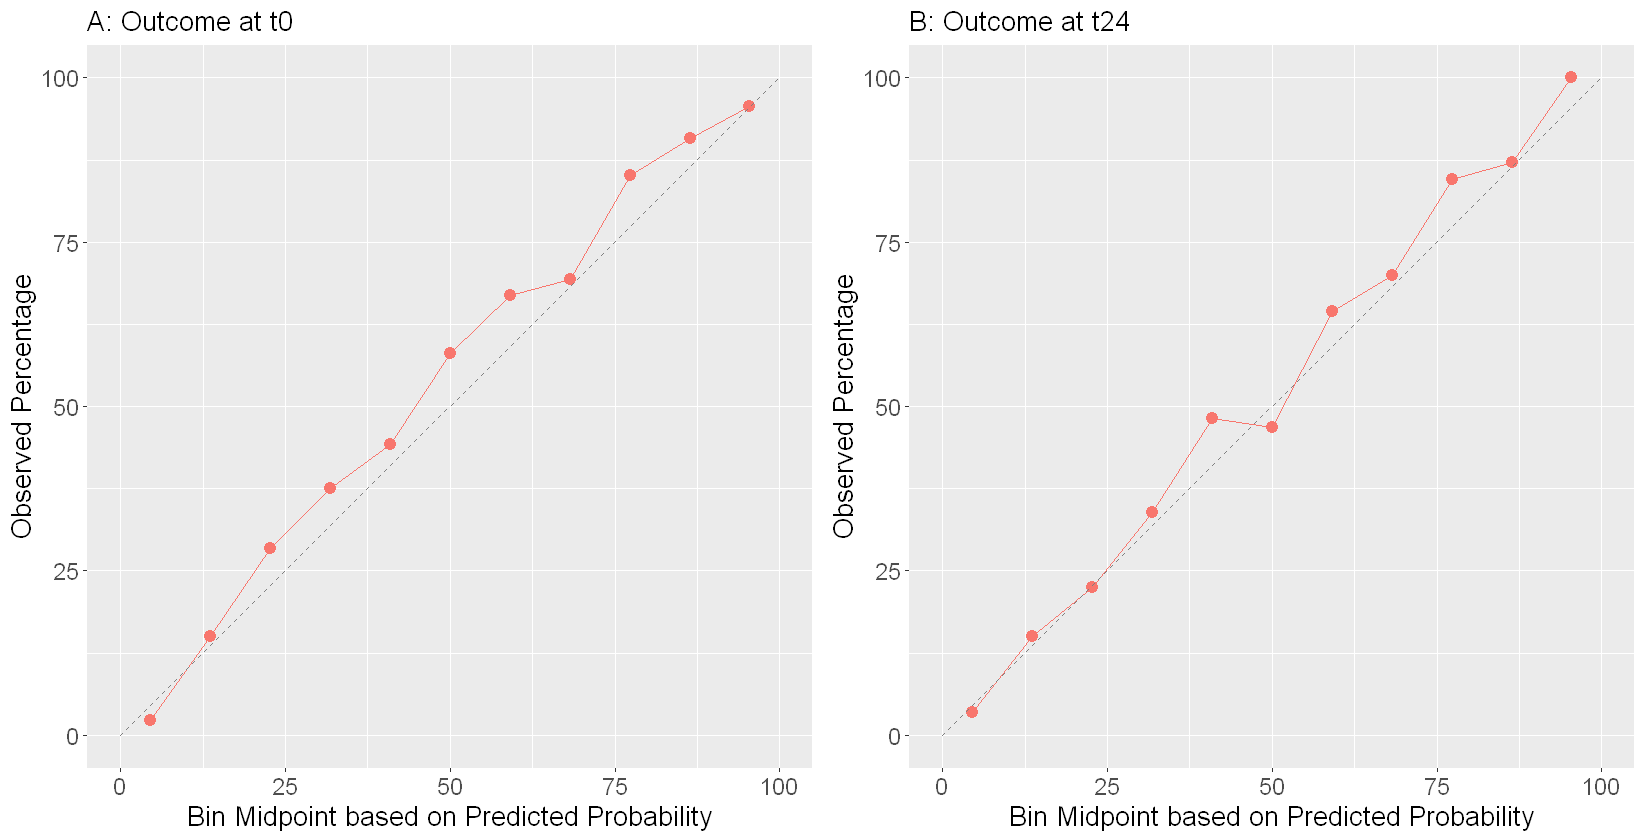

In [24]:
options(repr.plot.width=13.7, repr.plot.height=7)
# grid.arrange(p1, p2, ncol=2)

plotlist <- list(p1,p2)
# to save side-by-side picture
plot_grid(plotlist=plotlist)

# no "page 1 of 1" on top of the saved fig as with glist from gridExtra
ggsave(filename = file.path(figuredir, "Fig3.3_calibration_plotsAB_notitle.png"), width = 14, height = 7, dpi = 1200) 

# or, but will have "page 1 of 1" on top of the saved figure
# plot_list <- vector("list", 2) 
# plot_list[[1]] <- p1
# plot_list[[2]] <- p2

# glist <- lapply(plot_list, ggplotGrob)

# ggsave(filename = file.path(figuredir, "Fig3_Calibration_plots.png"),
#        marrangeGrob(glist, nrow = 1, ncol = 2), 
#        width = 14, height = 7, dpi = 1200)

In [ ]:
# typeof(results$label_max24)
# brier <- results %>% filter(label_max24 == 1) %>% select(label_max24, lgbm24max)
# mean((results$label_max24 - results$lgbm24max)^2)

In [19]:
# Confusion matrix 
cmatrix <- function(label, pred, cutoff) {
    cat("cutoff = ", cutoff, "\n")
    pred2 = ifelse(pred > cutoff, 1, 0)
    
#     typeof(results$lgbm24max2)
#     typeof(results$label_max24)

    print(caret::confusionMatrix(factor(pred2), 
                       factor(label), 
                       positive='1'))
}

In [20]:
# Confusion matrix 2nd outcome at different cut-off p
p=0.609
cmatrix(results$first_label, results$pred_first, p)
cmatrix(results$death_24hr_recent_label, results$pred_death_24hr_recent, p)

cutoff =  0.609 
Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 10781  1119
         1    99   419
                                          
               Accuracy : 0.9019          
                 95% CI : (0.8966, 0.9071)
    No Information Rate : 0.8761          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3682          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.27243         
            Specificity : 0.99090         
         Pos Pred Value : 0.80888         
         Neg Pred Value : 0.90597         
             Prevalence : 0.12385         
         Detection Rate : 0.03374         
   Detection Prevalence : 0.04171         
      Balanced Accuracy : 0.63167         
                                          
       'Positive' Class : 1               
 

### OLD stuff

In [ ]:
under24max <- results %>% filter(admit_label==0, label_max24==1) %>%
                mutate(pred2 = ifelse(lgbm24max > 0.609, 1, 0))
nrow(under24max)
sum(under24max$pred2)

under24 <- results %>% filter(admit_label==0, label_24hr_recent==1) %>%
            mutate(pred2 = ifelse(lgbm24 > 0.609, 1, 0))
nrow(under24)
sum(under24$pred2)

In [ ]:
under24 %>% arrange(-lgbm24max)

In [ ]:
death <- read.csv("./Data/full_cohort_2019_deaths_with_labels.csv")
nrow(death)
colnames(death)
death$admit_death_delta
head(death[, c("admit_death_delta", "death_date_jittered", "admit_date")])

In [ ]:
death <- death %>% filter(admit_death_delta %in% c("0 days", "1 days"), admit_label==0)
death <- death %>% select(inpatient_data_id_coded, admit_death_delta, death_date_jittered, 
                          admit_date, admit_label, label_24hr_recent, label_max24)
death
# death[, c("pat_enc_csn_id_coded", "admit_death_delta", "death_date_jittered", "admit_date", "admit_label", "label_24hr_recent", "label_max24")]

In [ ]:
deaths <- read.csv("./Data/labels_deaths_2019_2018_dates.csv")
nrow(deaths)
colnames(deaths)

In [ ]:
library(lubridate)

In [ ]:
deaths <- deaths %>% select("inpatient_data_id_coded", "admit_time", "admit_label", "label_24hr_recent", "label_max24", 
                            'death_date_2018', 'death_date_2019', 'died') %>%
            filter(died == "True", admit_label==0)
#                             filter(admit_death_delta %in% c("0 days", "1 days"), admit_label==1) 

deaths <- deaths %>% mutate(death_days = difftime(date(ymd(death_date_2018, tz = "UTC")), 
                                                  date(ymd_hms(admit_time, tz = "UTC")), units = "days"))

In [ ]:
deaths

In [ ]:
deaths <- deaths %>% filter(death_days <= 1, death_days >=0)
deaths

In [ ]:
options(scipen = 999)
death$inpatient_data_id_coded %in% deaths$inpatient_data_id_coded
death$inpatient_data_id_coded %in% results$inpatient_data_id_coded
head(results[, c("inpatient_data_id_coded", "admit_label")])

In [ ]:
results_death <- results %>% select(inpatient_data_id_coded, lgbm24, lgbm24max, admit_time) %>% right_join(death)
death
results_death %>% arrange(label_max24)